In [1]:
import tensorflow as tf
import cv2
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

In [2]:
img_array = cv2.imread("./dataset_new/test/Closed/_3.jpg", cv2.IMREAD_GRAYSCALE)

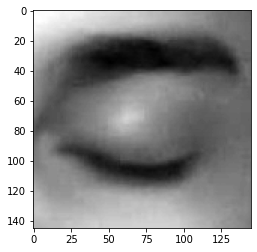

In [3]:
plt.imshow(img_array,cmap="gray")

In [4]:
import os
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
from keras.utils.np_utils import to_categorical
import random,shutil
from keras.models import Sequential
from keras.layers import Dropout,Conv2D,Flatten,Dense, MaxPooling2D, BatchNormalization
from keras.models import load_model


In [5]:
def generator(dir, gen=image.ImageDataGenerator(rescale=1./255), shuffle=True,batch_size=1,target_size=(24,24),class_mode='categorical'):

    return gen.flow_from_directory(dir,batch_size=batch_size,shuffle=shuffle,color_mode='grayscale',class_mode=class_mode,target_size=target_size)

BS= 32
TS=(24,24)
train_batch= generator('./dataset_new/train',shuffle=True, batch_size=BS,target_size=TS)
valid_batch= generator('./dataset_new/test',shuffle=True, batch_size=BS,target_size=TS)
SPE= len(train_batch.classes)//BS
VS = len(valid_batch.classes)//BS
print(SPE,VS)

Found 2467 images belonging to 4 classes.
Found 433 images belonging to 4 classes.
77 13


In [6]:
img,labels= next(train_batch)
print(img.shape)

(32, 24, 24, 1)


In [7]:
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(24,24,1)),
    MaxPooling2D(pool_size=(1,1)),
    Conv2D(32,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(1,1)),
#32 convolution filters used each of size 3x3
#again
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(1,1)),

#64 convolution filters used each of size 3x3
#choose the best features via pooling


#randomly turn neurons on and off to improve convergence
    Dropout(0.25),
#flatten since too many dimensions, we only want a classification output
    Flatten(),
#fully connected to get all relevant data
    Dense(128, activation='relu'),
#one more dropout for convergence' sake :) 
    Dropout(0.5),
#output a softmax to squash the matrix into output probabilities
    Dense(4, activation='softmax')
])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 22, 22, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 18, 18, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 18, 18, 64)        0

In [9]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
# we generally use crossentropy for more number of classes/folder but for 2 classes we use binary_crossentropy or categorical_crossentropy
# and adam is most use optimizer for both binary and more classification.

In [10]:
history = model.fit(train_batch, validation_data=valid_batch, epochs=10, steps_per_epoch=SPE, validation_steps=VS)

Epoch 1/10
77/77 [==============================] - 34s 446ms/step - loss: 0.6502 - accuracy: 0.7084 - val_loss: 0.3970 - val_accuracy: 0.8173
Epoch 2/10
77/77 [==============================] - 14s 176ms/step - loss: 0.3847 - accuracy: 0.8140 - val_loss: 0.3885 - val_accuracy: 0.8269
Epoch 3/10
77/77 [==============================] - 13s 169ms/step - loss: 0.3397 - accuracy: 0.8402 - val_loss: 0.3127 - val_accuracy: 0.8365
Epoch 4/10
77/77 [==============================] - 13s 167ms/step - loss: 0.2761 - accuracy: 0.8706 - val_loss: 0.2897 - val_accuracy: 0.8462
Epoch 5/10
77/77 [==============================] - 13s 167ms/step - loss: 0.2399 - accuracy: 0.8953 - val_loss: 0.2832 - val_accuracy: 0.8798
Epoch 6/10
77/77 [==============================] - 13s 170ms/step - loss: 0.2054 - accuracy: 0.9125 - val_loss: 0.2936 - val_accuracy: 0.8798
Epoch 7/10
77/77 [==============================] - 14s 182ms/step - loss: 0.1840 - accuracy: 0.9248 - val_loss: 0.2127 - val_accuracy: 0.9062

In [11]:
model.save('models/my_trained_model1.h5')

# Graph Plotting of trained data. 

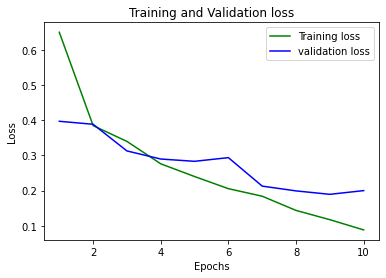

In [12]:
# the graph of the training loss vs. validation loss over the number of epochs
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,11)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

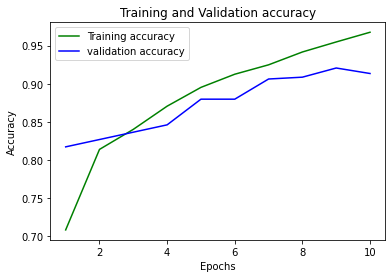

In [13]:
# the graph of training accuracy vs. validation accuracy over the number of epochs.
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(1,11)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# REAL-TIME LIVE VIDEO TESTING

In [1]:
import cv2
import os
from keras.models import load_model
import numpy as np
from pygame import mixer
import time

mixer.init()
sound = mixer.Sound('alarm.wav')

face = cv2.CascadeClassifier('haar_cascade_files\haarcascade_frontalface_alt.xml')
leye = cv2.CascadeClassifier('haar_cascade_files\haarcascade_lefteye_2splits.xml')
reye = cv2.CascadeClassifier('haar_cascade_files\haarcascade_righteye_2splits.xml')

lbl=['Close','Open']

model = load_model('models/my_trained_model2.h5')
path = os.getcwd()
cap = cv2.VideoCapture(0)
font = cv2.FONT_HERSHEY_COMPLEX_SMALL
count=0
score=0
thicc=2
rpred=[99]
lpred=[99]

while(True):
    ret, frame = cap.read()
    height,width = frame.shape[:2]

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    faces = face.detectMultiScale(gray,minNeighbors=5,scaleFactor=1.1,minSize=(25,25))
    left_eye = leye.detectMultiScale(gray)
    right_eye =  reye.detectMultiScale(gray)

    cv2.rectangle(frame, (0,height-50) , (200,height) , (0,0,0) , thickness=cv2.FILLED )

    # Face Cascadding using Haar cascade
    for (x,y,w,h) in faces:
        cv2.rectangle(frame, (x,y) , (x+w,y+h) , (0,255,000) , 1 )

    # Right eye Cascadding using Haar cascade
    for (x,y,w,h) in right_eye:
        r_eye=frame[y:y+h,x:x+w]
        count=count+1
        r_eye = cv2.cvtColor(r_eye,cv2.COLOR_BGR2GRAY)
        r_eye = cv2.resize(r_eye,(24,24))
        r_eye= r_eye/255                                     # Normalising the image
        r_eye=  r_eye.reshape(24,24,-1)
        r_eye = np.expand_dims(r_eye,axis=0)
        rpred = model.predict_classes(r_eye)
        if(rpred[0]==1):
            lbl='Open' 
        if(rpred[0]==0):
            lbl='Closed'
        break

    # Left eye Cascadding using Haar cascade
    for (x,y,w,h) in left_eye:
        l_eye=frame[y:y+h,x:x+w]
        count=count+1
        l_eye = cv2.cvtColor(l_eye,cv2.COLOR_BGR2GRAY)  
        l_eye = cv2.resize(l_eye,(24,24))
        l_eye= l_eye/255                                    # NOrmalising the image
        l_eye=l_eye.reshape(24,24,-1)
        l_eye = np.expand_dims(l_eye,axis=0)
        lpred = model.predict_classes(l_eye)
        if(lpred[0]==1):
            lbl='Open'   
        if(lpred[0]==0):
            lbl='Closed'
        break

    if(rpred[0]==0 and lpred[0]==0):
        score=score+1
        cv2.putText(frame,"Closed",(10,height-20), font, 1,(255,255,255),1,cv2.LINE_AA)
    # if(rpred[0]==1 or lpred[0]==1):

    else:
        score=score-1
        cv2.putText(frame,"Open",(10,height-20), font, 1,(255,255,255),1,cv2.LINE_AA)    
        
    if(score<0):
        score=0   
    cv2.putText(frame,'Score:'+str(score),(100,height-20), font, 1,(255,255,255),1,cv2.LINE_AA)
    if(score>15):
        # person is feeling sleepy so we beep the alarm
        cv2.imwrite(os.path.join(path,'image.jpg'),frame)
        try:
            sound.play()
            
        except:  # isplaying = False
            pass
        if(thicc<16):
            thicc= thicc+2
        else:
            thicc=thicc-2
            if(thicc<2):
                thicc=2
        cv2.rectangle(frame,(0,0),(width,height),(0,0,255),thicc) 

    cv2.imshow('frame',frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

pygame 2.0.1 (SDL 2.0.14, Python 3.8.2)
Hello from the pygame community. https://www.pygame.org/contribute.html
Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


KeyboardInterrupt: 